<a href="https://colab.research.google.com/github/mariapaulasag/Vae_Model_python/blob/main/VAE_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Libraries 
import numpy as np 
import pandas as pd 
from google.colab import files
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
import h5py
from numpy.random import seed
seed(1)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)



In [ ]:
!pip install tensorflow==1.14.0
!pip install keras== 2.2.4

ERROR: Could not find a version that satisfies the requirement keras== (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2)
ERROR: No matching distribution found for keras==


In [ ]:
print('TensorFlow version: ', tf.__version__) 
print('Keras version: ', keras.__version__)

TensorFlow version:  1.14.0
Keras version:  2.2.4-tf


In [ ]:
#Importing files from the computer
uploaded = files.upload()

Saving network_attack_data.csv to network_attack_data.csv


In [ ]:
network = pd.read_csv('network_attack_data.csv') #loading the dataset using pandas
network.head() # displaying the first 5 rows

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,Label
0,109998919,4,3,525,0.0,520,0,131.25,259.177385,0,...,32,5735.0,0.0,5735.0,5735.0,110000000.0,0.0,110000000.0,110000000.0,1
1,109993343,4,3,531,0.0,520,0,132.75,258.218738,0,...,32,5437.0,0.0,5437.0,5437.0,110000000.0,0.0,110000000.0,110000000.0,1
2,109988359,4,3,535,0.0,520,0,133.75,257.597069,0,...,32,5505.0,0.0,5505.0,5505.0,110000000.0,0.0,110000000.0,110000000.0,1
3,109982960,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5303.0,0.0,5303.0,5303.0,110000000.0,0.0,110000000.0,110000000.0,1
4,109977744,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5356.0,0.0,5356.0,5356.0,110000000.0,0.0,110000000.0,110000000.0,1


In [ ]:
network['Label'].value_counts() 

0    22987
1     5498
Name: Label, dtype: int64

In [ ]:
#Saving the “benign” and “attack” dataframe separately. 

benign = network['Label']== 0 # creating a dataframe for “benign” network
attack= network['Label']!= 0  # creating dataframe for “attack” network

network_benign = network[benign]
network_attack = network[attack]

print(f"benign count: {len(network_benign)}")
print(f"attack count: {len(network_attack)}")

benign count: 22987
attack count: 5498


In [ ]:
#Droping "label" column
network = network.drop('Label',axis=1) 

In [ ]:
#converting benign and attack dataframes to numpy arrays
x_benign = network_benign.drop('Label',axis=1).values 
y_benign = network_benign['Label'].values

x_attack = network_attack.drop('Label',axis=1).values 
y_attack = network_attack['Label'].values

print(x_benign.shape, x_attack.shape)
print(y_benign.shape, y_attack.shape)

(22987, 76) (5498, 76)
(22987,) (5498,)


In [ ]:
#Splitting the data into test and train
x_benign_train, x_benign_test = train_test_split(x_benign, test_size=0.25, random_state=40) 
print(x_benign_train.shape, x_benign_test.shape)

(17240, 76) (5747, 76)


In [ ]:
#Data Scaling using Standard scalar
scaler=StandardScaler()
x_benign_tr_scaled= scaler.fit_transform(x_benign_train) # fit_transform on train data
x_benign_tst_scaled= scaler.transform(x_benign_test) # transform on test data
x_attack_scaled= scaler.transform(x_attack) # transform on test data

In [ ]:
#Setting the hyperparameter values
batch_size = 32
original_dim = 76 
latent_dim = 10  
hidden_layer_sizes =50
epochs = 100
epsilon_std = 1.0 


Using Keras Functional API, defining the encoder, sampling layer, the decoder and instantiate the VAE model.

In [ ]:
#Defining the encoder
x = keras.layers.Input(shape=(original_dim,)) 
h1 = keras.layers.Dense(50, activation='relu')(x) # First hidden layer 
h2 = keras.layers.Dense(50, activation='relu')(h1) # Second hidden layer
z_mean = keras.layers.Dense(latent_dim)(h2) # Latent layer
z_log_var = keras.layers.Dense(latent_dim)(h2) # latent_dim = 10

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
#Defining sampling layer
K = keras.backend

def sampling(args):
    z_mean, z_log_var = args 
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
#Latent layer
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

In [ ]:
#Defining the decoder
decoder_h1 = keras.layers.Dense(50, activation='relu')
decoder_h2 = keras.layers.Dense(50, activation='relu') 
h_decoded = decoder_h2(z)

decoder_mean = keras.layers.Dense(original_dim)  
x_decoded_mean = decoder_mean(h_decoded) 

* Defining the VAE loss function and compiling the model using this loss metric and optimizer to be used is Adam. 
* The learning rate adjusted value to 0.001.


In [ ]:
# Instantiate the VAE model
vae = keras.models.Model(x, x_decoded_mean)

In [ ]:
def vae_loss(feature, reconstructed): 
    reconstruction_loss = keras.losses.binary_crossentropy(feature, reconstructed) 
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

In [ ]:
# Compiling the VAE model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=vae_loss)
vae.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 76)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           3850        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           510         dense_1[0][0]                    
______________________________________________________________________________________________

Training the model with batch_size and epochs set above. Displaying the loss curve during training.

In [ ]:
history= vae.fit(x_benign_tr_scaled ,x_benign_tr_scaled, verbose = 1, batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2)

Train on 13792 samples, validate on 3448 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
13792/13792 [==============================] - 1s 84us/sample - loss: -0.2513 - val_loss: -0.7390
Epoch 2/100
13792/13792 [==============================] - 1s 65us/sample - loss: -1.0495 - val_loss: -1.2965
Epoch 3/100
13792/13792 [==============================] - 1s 63us/sample - loss: -1.5211 - val_loss: -1.6091
Epoch 4/100
13792/13792 [==============================] - 1s 65us/sample - loss: -1.7630 - val_loss: -1.7170
Epoch 5/100
13792/13792 [==============================] - 1s 63us/sample - loss: -1.7980 - val_loss: -1.8102
Epoch 6/100
13792/13792 [==============================] - 1s 63us/sample - loss: -1.9286 - val_loss: -1.9535
Epoch 7/100
13792/13792 [==============================] - 1s 62us/sample - loss: -1.9912 - val_loss: -1.9575
Epoch 8/100
13792/13792 [==============================] - 1s 62us/sample - loss: -2.10

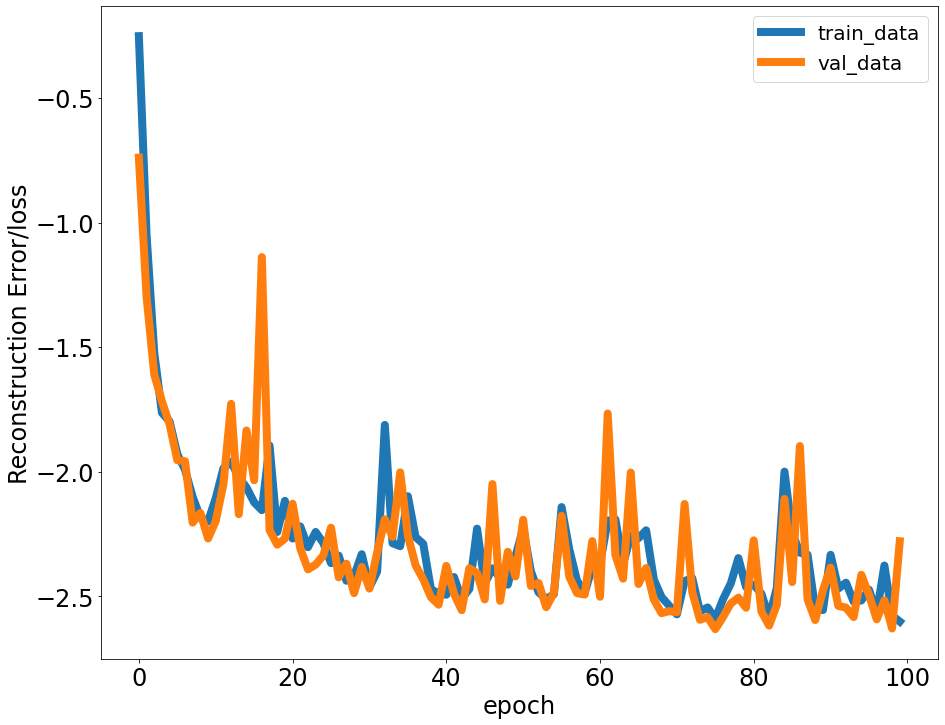

In [ ]:
# loss plot train-validation
import matplotlib as mpl

mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
#plt.title('model loss',fontsize = 24)
plt.ylabel('Reconstruction Error/loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data', 'val_data'], loc='best',fontsize = 20)
plt.show()

In [ ]:
#saving model
vae.save("VAE_network.h5") 

In [ ]:
# Making predictions on test data
pred2 = vae.predict(x_benign_tst_scaled) # predictions on test benign data
score2 = np.sqrt(metrics.mean_squared_error(pred2,x_benign_tst_scaled))

pred3 = vae.predict(x_attack_scaled) # predictions on test attack data
score3 = np.sqrt(metrics.mean_squared_error(pred3,x_attack_scaled))


print(f"Benign_test_data_score Score (RMSE): {score2}")
print(f"Attack_test_data_score (RMSE): {score3}")

Benign_test_data_score Score (RMSE): 2.9873215048007102
Attack_test_data_score (RMSE): 4.502405361641583


In [ ]:
#Combining the test data (benign) and attack data
tst_obs = x_benign_tst_scaled.copy() 
print(tst_obs.shape)
tst_obs = np.append(tst_obs, x_attack_scaled, axis=0) # Combining test benign and test attack data 
print(tst_obs.shape)
print(y_benign[0:5747].shape)

(5747, 76)
(11245, 76)
(5747,)


In [ ]:
Y_obs = y_benign[0:5747].copy() 
Y_obs  = np.append(Y_obs, y_attack, axis=0)
print(Y_obs.shape)

(11245,)


In [ ]:
# Making predictions using the VAE model
test_preds=vae.predict(tst_obs)
mse_test = np.mean(np.power(tst_obs- test_preds, 2), axis=1)

In [ ]:
tst_error_data = pd.DataFrame({'recon_error': mse_test,'Label': Y_obs})

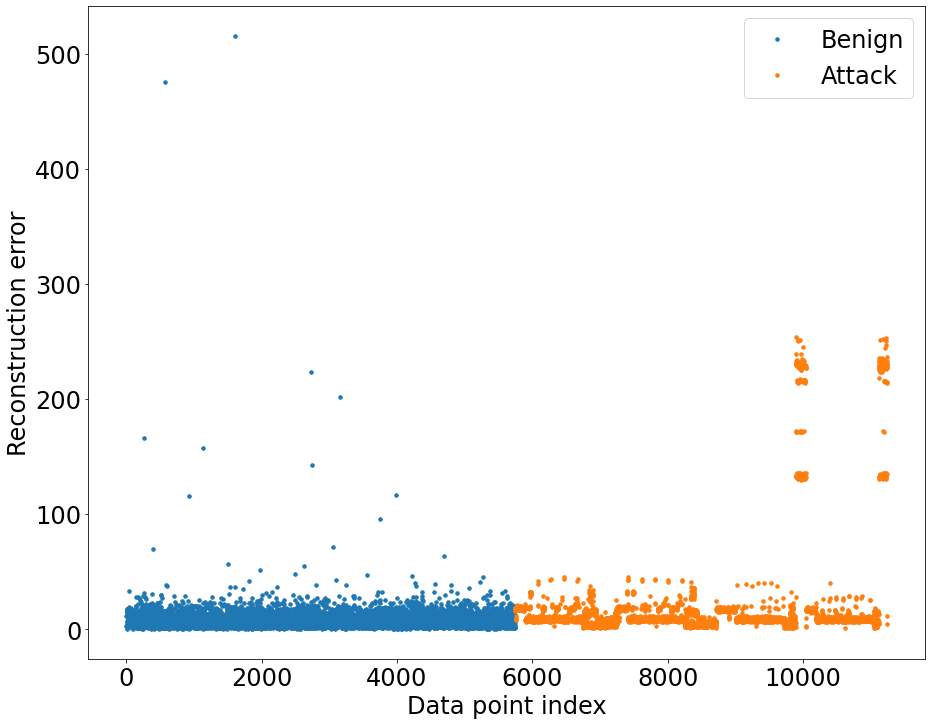

In [ ]:
#RE for different Label of data

group1 = tst_error_data.groupby('Label')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Attack" if name == 1 else "Benign")
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [ ]:
# Computing confusion matrix for test data (Attack+Benign)

threshold=0.01  # selected using trial and error

y_pred = [1 if e > threshold else 0 for e in tst_error_data.recon_error.values]

cm= confusion_matrix(tst_error_data.Label, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))

Confusion matrix:
[[   0 5747]
 [   0 5498]]

Total number of true positives 5498
Total number of false negatives 0
Total number of false positives 5747
Total number of true negatives 0

Classifier Accuracy: 48.89%
True Positive Rate (TPR/Recall/Sensitivity): 100.00%
True Negative Rate (TNR/Specificity/selectivity):0.00%
False Positive Rate (FPR): 100.00%
False Negative Rate (FNR): 0.00%
Precision/Positive Predictive value:48.89%
F1-Score: 65.68%


# ROC curve

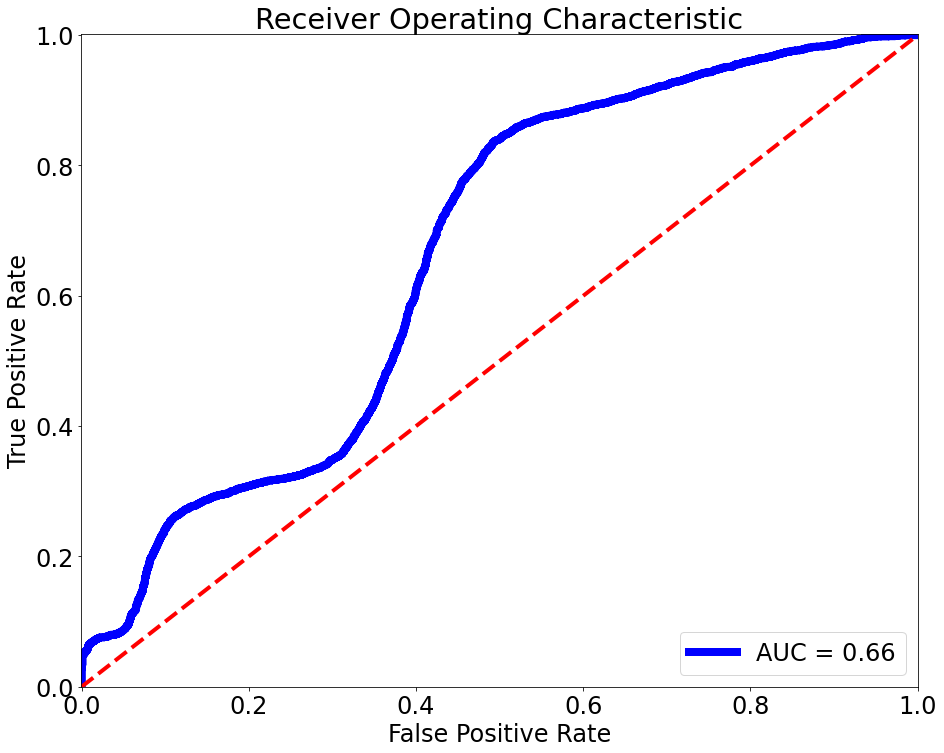

In [ ]:
##########  ROC GRAPH  #######

fpr, tpr, thresholds = roc_curve(tst_error_data.Label,tst_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()